In [64]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')

# Cost of Decoupled Namespace

1 server 1 client

In [65]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)

In [66]:
def mdtest(fname):
    with open(fname) as f:
        start = end = ""
        data = json.load(f)
        for line in data['stdout_lines']:
            if "started" in line: start = line.split()[4]
            if "finished" in line: end = line.split()[4]
        result = to_seconds(end) - to_seconds(start)
        if result < 0: return 0
        return result    

job,RPCs-nostream,RPCs-stream,create-nostream,create-stream,persist-nostream,persist-stream,save-nostream,save-stream,snapshot-nostream,snapshot-stream,...,save,persist,v.apply,create+v.apply,create+save,create+save+v.apply,RPCs+save,create+persist,create+persist+v.apply,RPCs+stream
nfile,,,,,,,,,,,,,,,,,,,,,
10.0,0.0,0.0,0.188724,0.203539,0.362117,0.380895,0.169598,0.167440,1.805724,1.811736,...,-0.019126,0.173393,0.055121,0.243845,0.169598,0.224719,-0.019126,0.362117,0.417238,0.0
100.0,0.0,0.0,0.206786,0.186209,0.414737,0.373343,0.166439,0.244507,1.765902,1.694036,...,-0.040347,0.207951,0.046811,0.253597,0.166439,0.213250,-0.040347,0.414737,0.461548,0.0
1000.0,1.0,2.0,0.257140,0.252480,0.427159,0.491191,0.265991,0.234462,1.776533,1.751670,...,0.008851,0.170019,0.021868,0.279008,0.265991,0.287859,1.008851,0.427159,0.449027,2.0
10000.0,13.0,15.0,0.295030,0.304040,0.893548,0.869441,0.851148,0.826809,1.632538,1.809444,...,0.556118,0.598518,0.242718,0.537748,0.851148,1.093866,13.556118,0.893548,1.136266,15.0
100000.0,131.0,151.0,1.471774,1.432117,5.618294,5.506952,7.366037,7.094620,1.825013,1.665423,...,5.894263,4.146520,1.885964,3.357738,7.366037,9.252001,136.894263,5.618294,7.504258,151.0


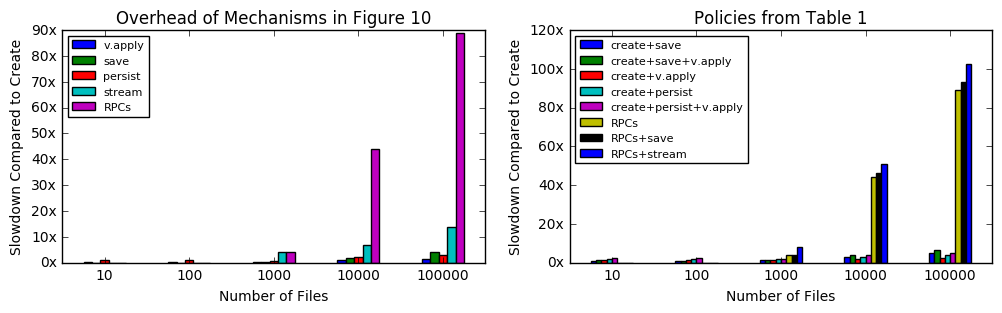

In [76]:
exp = "experiments/fuse/batchfs/results-run3/"
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])

# get nostream
for nfiles in ['10', '100', '1000', '10000', '100000']:
    for stream in ["-stream", "-nostream"]:
        with open(exp + nfiles + '/summary' + stream + '.txt') as f:
            d = pd.read_csv(f, names=['job', 'time', 'delta'])
            d['rtime'] = d['delta'].apply(to_seconds)
            d['nfile'] = np.full(len(d), nfiles)
            del d['time'], d['delta']
            d['job'] = d['job'] + stream
            df = df.append(d, ignore_index=True)
        df.loc[len(df)] = ["RPCs" + stream] + [float(nfiles)] + [mdtest(exp + nfiles + "/summary-rpcs" + stream + ".txt")]
    
# massage into graphable format
df = df.pivot(index='nfile', values='rtime', columns='job')
df['RPCs'] = df['RPCs-nostream']
df['stream'] = df['RPCs-stream'] - df['RPCs-nostream']
df['create'] = df['create-nostream']
df['save'] = df['save-nostream'] - df['create']
df['persist'] = df['persist-nostream'] - df['create']
df['v.apply'] = df['v.apply-nostream'] - df['create']

# prune
creates = df['create']
slowdowns = df[['v.apply', 'save', 'persist', 'stream', 'RPCs']]
slowdowns = slowdowns[:].div(creates, axis=0)

# graph slowdowns
slowdowns.plot.bar(ax=ax[0])
ax[0].set_title("Overhead of Mechanisms in Figure 10")
ax[0].set_ylabel("Slowdown Compared to Create")
ax[0].legend(fontsize=8, loc='upper left')
ax[0].set_ylim(0)
#ax[0].set_yscale('log')
ax[0].set_xticklabels([10, 100, 1000, 10000, 100000], rotation=0)
ax[0].set_xlabel("Number of Files")
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))


# graph policies
policies = df
policies['create'] = creates
policies['create+v.apply'] = creates + df['v.apply']
policies['RPCs'] = df['RPCs']
policies['create+save'] = creates + df['save']
policies['create+save+v.apply'] = creates + df['save'] + df['v.apply']
policies['RPCs+save'] = df['RPCs'] + df['save']
policies['create+persist'] = creates + df['persist']
policies['create+persist+v.apply'] = creates + df['persist'] + df['v.apply']
policies['RPCs+stream'] = df['RPCs'] + df['stream']

# normalize and graph
policies = policies[:].div(creates, axis=0)
policies = policies[['create+save', 'create+save+v.apply',
                     'create+v.apply','create+persist', 'create+persist+v.apply', 
                     'RPCs', 'RPCs+save','RPCs+stream']]
policies.plot.bar(ax=ax[1])
ax[1].set_ylim(0)
ax[1].set_title("Policies from Table 1")
ax[1].set_ylabel("Slowdown Compared to Create")
ax[1].legend(fontsize=8, loc='upper left')
ax[1].set_ylim(0)
ax[1].set_xticklabels([10, 100, 1000, 10000, 100000], rotation=0)
ax[1].set_xlabel("Number of Files")
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))


df

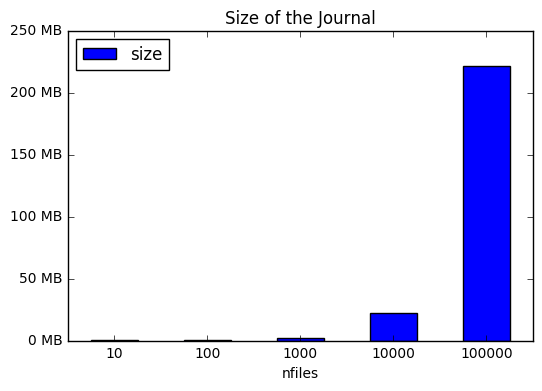

In [77]:
df = pd.DataFrame(columns=['nfiles', 'time', 'size'])

exp = "experiments/fuse/batchfs/results-run3/*/fsize.txt"
for fname in sorted(glob.glob(exp)):
    with open(fname) as f:
        d = pd.read_csv(f, names=['nfiles', 'time', 'size'])
        d['size'] = d['size']/(1024*1024)
        df = df.append(d, ignore_index=True)

df = df.drop_duplicates('nfiles')
fig, ax = plt.subplots(1, 1)
df.plot.bar(x='nfiles', y='size', ax=ax)
ax.set_title("Size of the Journal")
ax.set_xticklabels([10, 100, 1000, 10000, 100000], rotation=0)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f MB'))

